In [3]:
import os
os.chdir("drive/MyDrive/Datathon/Atmira Stock Prediction_Universidad Carlos III de Madrid_Enver") #SE ASUME QUE EL WORKING DIRECTORY ES DONDE ESTA ESTE DIRECTORIO

In [4]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from importlib import reload
import utils; reload(utils)
from utils import get_data_summary

### Cargar Datos:

In [5]:
estimar_df = pd.read_table("raw_data/Estimar2.txt", sep="|", decimal=',', na_values=['-'])
modelar_df = pd.read_table("raw_data/Modelar_UH2021.txt", sep="|", decimal=',', na_values=['-'])#.sample(frac=0.1) #small sample for EDA
target_col = "unidades_vendidas"

#cambiar fecha a tipo datetime
modelar_df['fecha'] = pd.to_datetime(modelar_df['fecha'],format="%d/%m/%Y %H:%M:%S")
estimar_df['fecha'] = pd.to_datetime(estimar_df['fecha'],format="%Y-%m-%d")

#eliminar filas duplicadas de modelar
modelar_df.drop_duplicates(subset=['fecha','id'],inplace=True)

### Analisis Exploratorio

In [ ]:
target_col = 'unidades_vendidas'
print("Informacion de modelar_df:")
get_data_summary(modelar_df,target_col)

Informacion de modelar_df:


,DataType,NumberOfMissingValues,CorrelationWithTarget,Mean,Median,Mode,MinValue,MaxValue,NumberOfUniqueValues,UniqueValues,FracUniqueVals
visitas,int64,0,0.394339,119.466,23.00,0,0,120045,4598,NaN,NaN
campaña,binary,0,0.120994,NaN,0.00,0,NaN,NaN,2,"[0, 1]","[0.999, 0.001]"
dia_atipico,int64,0,0.061805,0.063655,0.00,0,-1,1,3,NaN,NaN
antiguedad,float64,477989,0.038814,1074.66,831.00,677,126,5310,1154,NaN,NaN
categoria_dos,float64,4383,0.007855,189.172,192.00,336,2,343,182,NaN,NaN
precio,float64,1397989,-0.020050,31.1013,22.23,19.45,3.57,175.78,8191,NaN,NaN
id,int64,0,-0.035457,269635,287718.00,21972,21972,458660,4168,NaN,NaN
fecha,datetime64[ns],0,NaN,2016-01-30 10:32:46.323735040,NaN,2015-06-01T00:00:00.000000000,2015-06-01 00:00:00,2016-09-30 00:00:00,487,NaN,NaN
categoria_uno,object,0,NaN,NaN,NaN,A,NaN,NaN,13,"[A, B, C, D, E, F, G, H, I, K, L, N, O]","[0.333, 0.157, 0.138, 0.098, 0.081, 0.079, 0.0..."
estado,object,0,NaN,NaN,NaN,No Rotura,NaN,NaN,3,"[No Rotura, Rotura, Transito]","[0.833, 0.154, 0.013]"


In [ ]:
print("Informacion de estimar_df:")
get_data_summary(estimar_df)

Informacion de estimar_df:


,DataType,NumberOfMissingValues,Mean,Median,Mode,MinValue,MaxValue,NumberOfUniqueValues,UniqueValues,FracUniqueVals
ColumnName,,,,,,,,,,
campaña,binary,0,NaN,0.00,0,NaN,NaN,2,"[0, 1]","[0.986, 0.014]"
fecha,datetime64[ns],0,2016-11-14 12:23:53.565896960,NaN,2016-10-01T00:00:00.000000000,2016-10-01 00:00:00,2016-12-31 00:00:00,92,NaN,NaN
categoria_dos,float64,438,163.75,155.00,82,2,343,163,NaN,NaN
precio,float64,0,26.9283,19.44,8.82,0,141.18,3324,NaN,NaN
antiguedad,int64,0,1059.63,826.00,586,35,5219,1110,NaN,NaN
dia_atipico,int64,0,0.277837,0.00,0,-1,1,3,NaN,NaN
id,int64,0,254764,264804.00,27144,21972,458660,2736,NaN,NaN
visitas,int64,0,305.88,75.00,0,0,289620,1896,NaN,NaN
categoria_uno,object,0,NaN,NaN,A,NaN,NaN,13,"[A, B, C, D, E, F, G, H, I, K, L, N, O]","[0.384, 0.129, 0.112, 0.08, 0.073, 0.067, 0.06..."


Como podemos observar, existen observaciones en el conjunto de modelado cuyo valor de la variable `estado` es igual a "Rotura" y este valor NO esta en el conjunto a estimar asi que lo que el modelo aprenda de `estado == Rotura` **no** sera util para realizar las predicciones de este conjunto. Tambien pasa lo mismo con `categoria_uno == D` 

Tamaño de las series de tiempo: 487.0
Numero de productos unicos: 4168


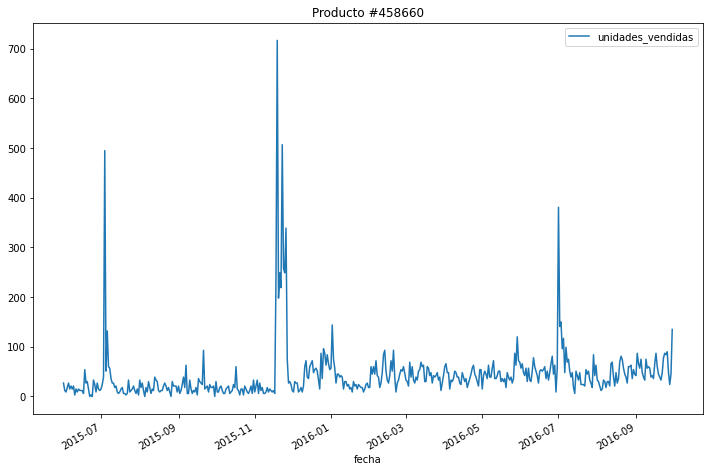

In [ ]:
#Agrupar por id
repeated = modelar_df.groupby('id').fecha.nunique().sort_values(ascending = False)
#Ejemplo de serie de tiempo
product_df = modelar_df.query(f'id == {repeated.index[20]}')
ax = product_df.plot('fecha','unidades_vendidas',figsize=(12,8),title = f'Producto #{repeated.index[0]}')
print("Tamaño de las series de tiempo:",repeated.mean());
print("Numero de productos unicos:",len(modelar_df.id.unique()));

Por lo tanto los datos que usaremos para modelar consisten de una serie de tiempo de 487 dias por cada uno de los 4168 productos en venta.

In [ ]:
487*4168 == len(modelar_df)

True

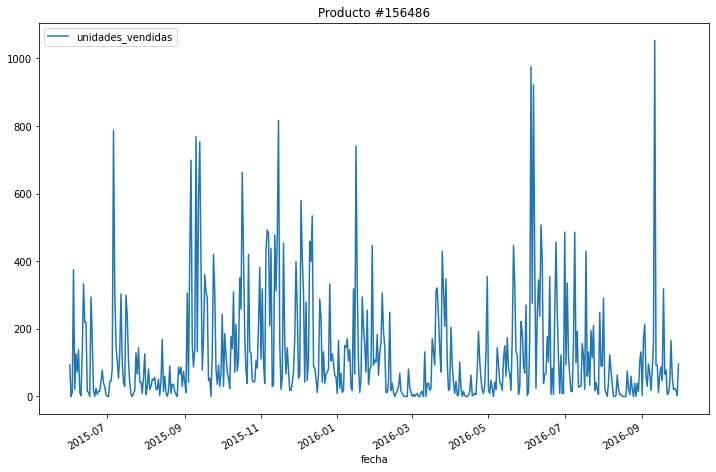

In [ ]:
#mas vendido
sold = modelar_df.groupby('id').unidades_vendidas.sum().sort_values(ascending = False)
most_sold = sold.index[0]
most_sold_df = modelar_df.query(f'id == {most_sold}')
ax = most_sold_df.plot('fecha','unidades_vendidas',figsize=(12,8), title = f'Producto #{most_sold}')

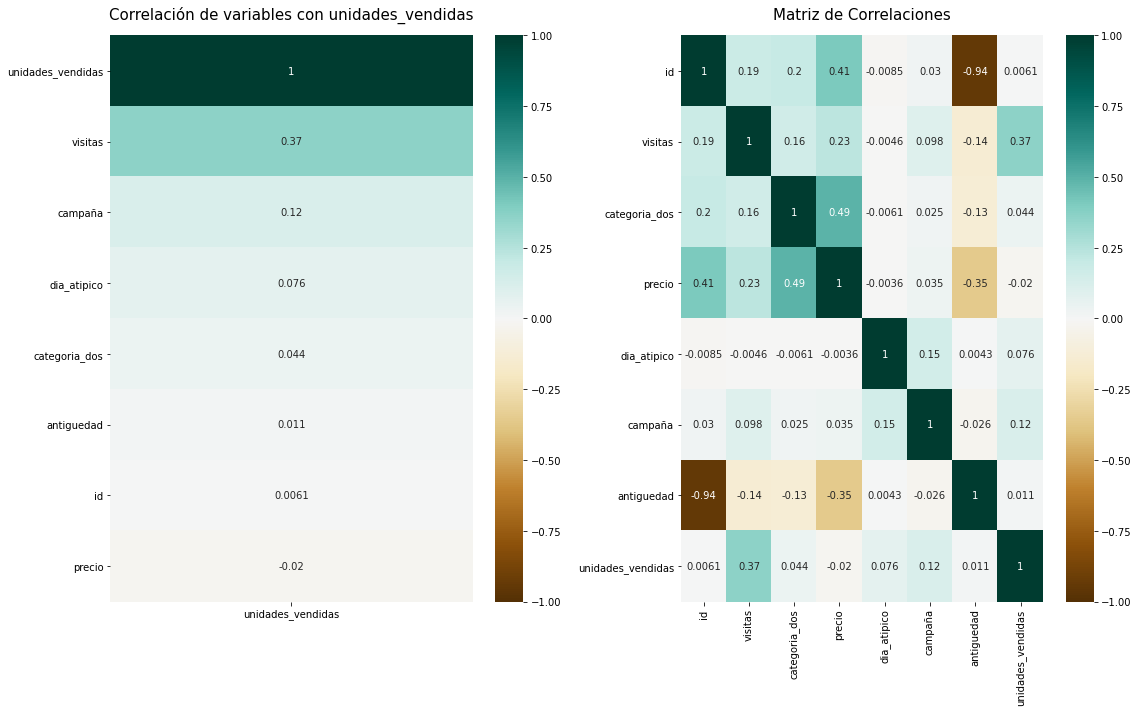

In [ ]:
#correlaciones
corrs_df = modelar_df[modelar_df.unidades_vendidas!=0]
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(16,10))
sns.heatmap(corrs_df.corr()[[target_col]].sort_values(by=target_col, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0])
sns.heatmap(corrs_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[1])
axes[0].set_title("Correlación de variables con unidades_vendidas",pad=16,fontsize=15);
axes[1].set_title("Matriz de Correlaciones",pad=16,fontsize=15)
fig.tight_layout();

### Analisis de variables categoricas

Variables Categoricas: `categoria_uno`, `estado`, `dia_atipico`, `campaña`

**1. categoria_uno**

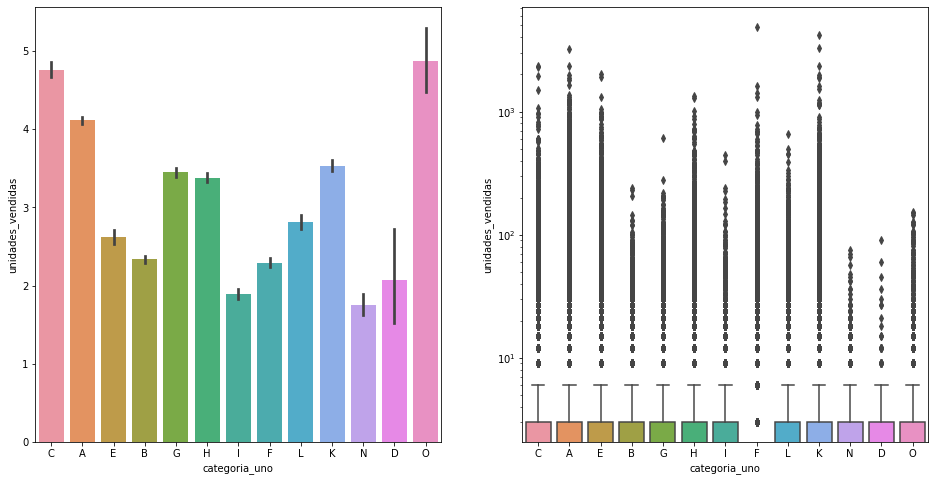

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(16,8))
sns.barplot(x='categoria_uno',y=modelar_df.unidades_vendidas,data=modelar_df, ax=axes[0]);
sns.boxplot(x='categoria_uno',y=(modelar_df.unidades_vendidas),data=modelar_df, ax=axes[1]);
axes[1].set_yscale('log');

**2. estado**

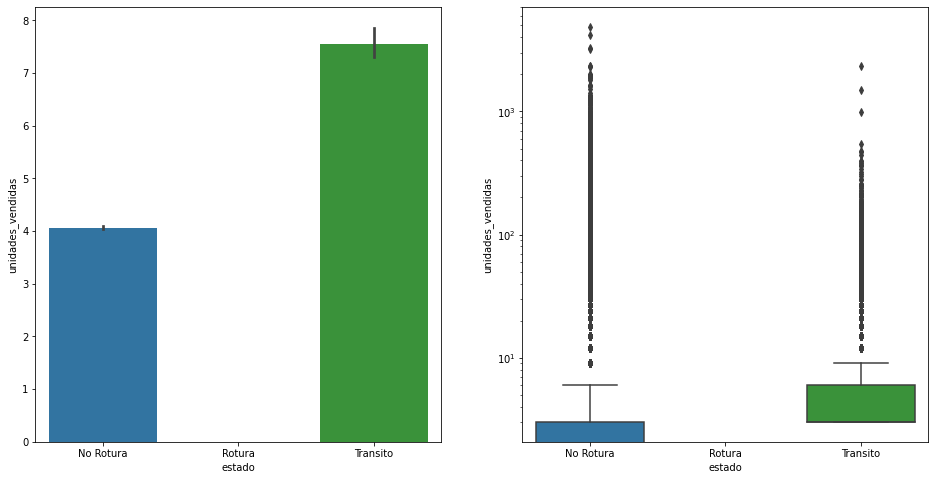

In [ ]:
cat = 'estado'
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(16,8))
sns.barplot(x=cat,y=modelar_df.unidades_vendidas,data=modelar_df, ax=axes[0]);
sns.boxplot(x=cat,y=(modelar_df.unidades_vendidas),data=modelar_df, ax=axes[1]);
axes[1].set_yscale('log');

**3. dia_atipico**

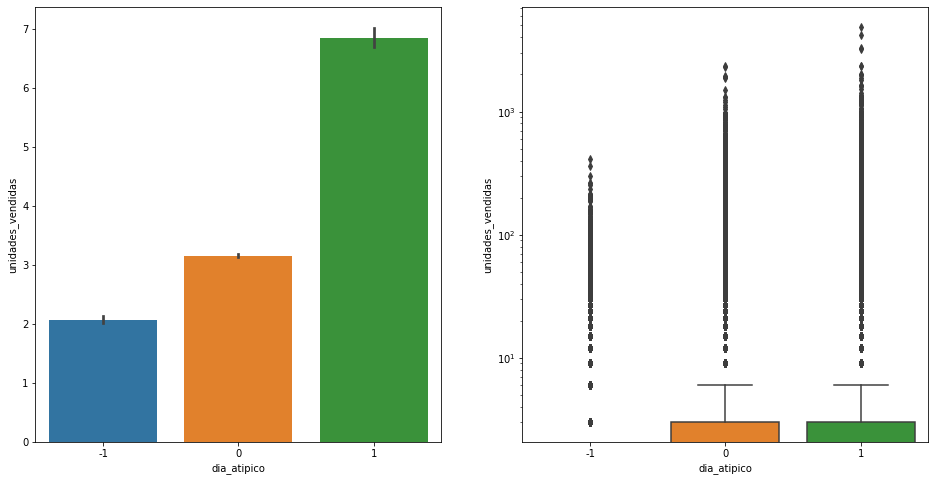

In [ ]:
cat = 'dia_atipico'
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(16,8))
sns.barplot(x=cat,y=modelar_df.unidades_vendidas,data=modelar_df, ax=axes[0]);
sns.boxplot(x=cat,y=(modelar_df.unidades_vendidas),data=modelar_df, ax=axes[1]);
axes[1].set_yscale('log');

**4. campaña**

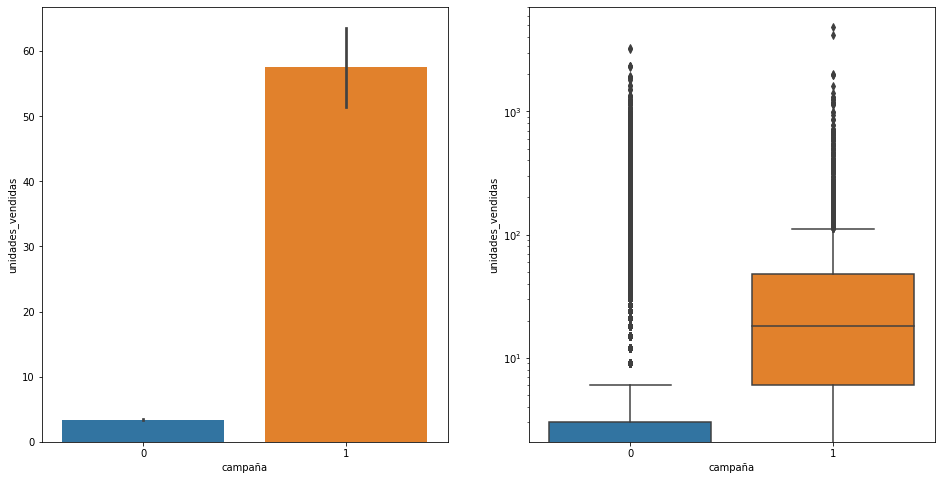

In [ ]:
cat = 'campaña'
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(16,8))
sns.barplot(x=cat,y=modelar_df.unidades_vendidas,data=modelar_df, ax=axes[0]);
sns.boxplot(x=cat,y=(modelar_df.unidades_vendidas),data=modelar_df, ax=axes[1]);
axes[1].set_yscale('log');

### Transformar 

In [6]:
#llamemos al dataset usado para procesamiento 'data'
data = modelar_df.copy()

#el dataset a estimar no contiene valores con estado=Rotura asi que eliminaremos esos del modelar
data = data[data.estado!='Rotura']

#tambien hay ids del modelar que no existen en el estimar, como no proveen informacion extra los quitaremos de aqui
data = data[data.id.isin(estimar_df.id)] #eliminar ids que no esten en el conjunto a estimar

#Defininir variables categoricas
data['dia_atipico'] = data['dia_atipico'].astype('category')
data['categoria_uno'] = data['categoria_uno'].astype('category')
data['estado'] = data['estado'].astype('category')

#ordenar por id y fecha
data = data.sort_values(['id','fecha'])

#eliminar categoria_dos, estado y antiguedad
data.drop(["categoria_dos",'estado','antiguedad'],axis=1,inplace=True)

In [7]:
#imputar valores no existentes en precio por sus mas cercanos en el pasado
data = data.sort_values(['id','fecha'])
id_dfs = [data[data.id==id_].fillna(method='ffill').fillna(method='bfill') for id_ in data.id.unique()]
data = pd.concat(id_dfs,axis=0)
get_data_summary(data,target_col)

,DataType,NumberOfMissingValues,CorrelationWithTarget,Mean,Median,Mode,MinValue,MaxValue,NumberOfUniqueValues,UniqueValues,FracUniqueVals
visitas,int64,0,0.388054,125.025,25.00,0,0,120045,3544,NaN,NaN
campaña,binary,0,0.103704,NaN,0.00,0,NaN,NaN,2,"[0, 1]","[0.999, 0.001]"
precio,float64,0,-0.040026,29.0078,20.61,8.82,3.57,175.78,6469,NaN,NaN
id,int64,0,-0.041527,258483,271946.00,31180,21972,458660,2736,NaN,NaN
categoria_uno,category,0,NaN,NaN,NaN,A,NaN,NaN,13,"[A, B, C, D, E, F, G, H, I, K, L, N, O]","[0.381, 0.12, 0.12, 0.085, 0.074, 0.073, 0.062..."
dia_atipico,category,0,NaN,NaN,NaN,0,NaN,NaN,3,"[-1, 0, 1]","[0.866, 0.099, 0.035]"
fecha,datetime64[ns],0,NaN,2016-01-28 22:09:42.159828736,NaN,2016-02-25T00:00:00.000000000,2015-06-01 00:00:00,2016-09-30 00:00:00,487,NaN,NaN
unidades_vendidas*,int64,0,1.000000,4.3069,0.00,0,0,4881,301,NaN,NaN


In [ ]:
#indexar por id de producto en las filas y fecha en las columnas
df = data.copy().set_index(["id","fecha"])[['unidades_vendidas','visitas','precio','campaña']].unstack(level=-1) 
df #multi-dataset compuesto por 4 datasets con valores para unidades_vendidas, visitas, precio y campaña respectivamente e indexado por id de producto en sus filas y fecha en sus columnas

unidades_vendidas                        ...    campaña                      
fecha         2015-06-01 2015-06-02 2015-06-03  ... 2016-09-28 2016-09-29 2016-09-30
id                                              ...                                 
21972                0.0        0.0        0.0  ...        0.0        0.0        0.0
23910                3.0        0.0        3.0  ...        0.0        0.0        0.0
27144                0.0        0.0        0.0  ...        0.0        0.0        0.0
27504                0.0        0.0        0.0  ...        NaN        NaN        NaN
30014                3.0        3.0        3.0  ...        0.0        0.0        0.0
...                  ...        ...        ...  ...        ...        ...        ...
454950               0.0        0.0        0.0  ...        0.0        0.0        0.0
457416               0.0        0.0        0.0  ...        0.0        0.0        0.0
457422               0.0        0.0        0.0  ...        NaN        NaN        NaN
458650               0.0        0.0        0.0  ...        0.0        0.0        0.0
458660               0.0        0.0        0.0  ...        0.0        0.0        0.0

[2736 rows x 1948 columns]

In [ ]:
#Si un producto no aparece en un periodo de tiempo se imputa como 0 para unidades_vendidas, visitas y campaña y como el ultimo precio que tenia para precio
df['unidades_vendidas'] = df['unidades_vendidas'].fillna(0)
df['visitas'] = df['visitas'].fillna(0)
df['campaña'] = df['campaña'].fillna(0)
df['precio'] = df['precio'].T.fillna(method='ffill').fillna(method='bfill').T

In [ ]:
#dataset de categorias por producto
categorias_df = data[['id','categoria_uno']].drop_duplicates()

#dataset de dias atipicos
dias_atipicos = data[['fecha','dia_atipico']].drop_duplicates()

Utilizaremos el metodo de [Multi-step-ahead forecasting](https://www.researchgate.net/publication/220894451_Multistep-Ahead_Time_Series_Prediction) para entrenar de manera independiente un modelo por cada dia que pretendamos estimar. Para hacer esto construiremos un conjunto de entrenamiento conteniendo variables temporales para estimar un solo dia por cada uno de los 92 dias que buscamos predecir del conjunto a estimar (92 modelos distintos). 

Dado esto, el siguiente paso es definir una funcion pipeline que dado un dataframe con una fila para cada uno de los $p$ productos, un dia `d` y numero entero `days_to_pred` devuelva un dataframe nuevo con : 
1. Nuevas variables basadas en los valores futuros a `d` de `visitas`, `campaña` y `precio` por cada uno de los `days_to_pred` dias a predecir. 
2. Nuevas variables sacando la media de variables como `visitas`, `unidades_vendidas` y `precio` de $n$ dias pasados a `d` para varias $n$. 
3. Nuevas variables basadas en pasados dias de campaña (Como el numero de veces que el producto ha estado en campaña en los ultimos $n$ dias para varias $n$) y tambien basado en futuros dias de campañá (Si/no habran dias de campaña en el futuro cercano por ejemplo).
4. Variables dummies para las variables categoricas como `dia_atipico` y `categoria_uno`.

Por esto el dataset de entrada a esta pipeline es indexado por el `id` del producto en sus filas y por `fecha` en sus columnas como hemos hecho arriba.

In [ ]:
def transform_pipeline(df,d,df_after = None,days_to_pred=30): #funcion de pipeline
  '''
  Recibe un dataset df y dia d y genera nuevas variables temporales basada en los dias `days_to_pred` a predecir
  '''
  if df_after is None:
    df_after = df
  def get_values_on_period(df,days_before,days_length):
    date_range = pd.date_range(d-pd.to_timedelta(days_before,'days'),d-pd.to_timedelta(days_before,'days')+pd.to_timedelta(days_length-1,'days'))
    date_range = date_range[~date_range.astype(str).str.contains('02-29')]
    return df[date_range]
  #1. Informacion de los dias a predecir
  X_list = [
       pd.DataFrame({ 
            f'visitas_{i}_despues' : df_after['visitas'][d+pd.to_timedelta(i,'days')].values.ravel(),
            # f'visitas_{i}_despues_cat' : np.select([df_after['visitas'][d+pd.to_timedelta(i,'days')].values.ravel() < x for x in(5,90,float("inf"))],[-1,0,1]),
            f'precio_{i}_despues' : df_after['precio'][d+pd.to_timedelta(i,'days')].values.ravel(),
            f'campana_{i}_despues' : df_after['campaña'][d+pd.to_timedelta(i,'days')].values.ravel(),
            f'demanda_alta_{i}_despues': (dias_atipicos[dias_atipicos.fecha==d+pd.to_timedelta(i,'days')].dia_atipico==1).astype(int).tolist()*len(df),
            f'demanda_baja_{i}_despues': (dias_atipicos[dias_atipicos.fecha==d+pd.to_timedelta(i,'days')].dia_atipico==-1).astype(int).tolist()*len(df),
            }
        ) for i in range(days_to_pred) if d+pd.to_timedelta(i,'days') in df_after['visitas'].columns
  ]
  #1. Informacion del pasado
  X_list = X_list + [
       pd.DataFrame({
            f'{var}_1_antes': get_values_on_period(df[var],1,1).values.ravel(),
            f'{var}_7_antes_avg': get_values_on_period(df[var],7,7).values.mean(axis=1),
            f'{var}_14_antes_avg': get_values_on_period(df[var],14,14).values.mean(axis=1),
            f'{var}_28_antes_avg': get_values_on_period(df[var],28,28).values.mean(axis=1),
            f'{var}_60_antes_avg': get_values_on_period(df[var],60,60).values.mean(axis=1),
            #f'{var}_120_antes_avg': get_values_on_period(df[var],120,120).values.mean(axis=1),
            }
        ) for var in ['unidades_vendidas','precio','visitas']
  ]
  #2.
  X_list = X_list + [ #conteo de cuantas veces el producto ha estado en campaña en dias pasados
       pd.DataFrame({
               f'count_campana_{i}_antes': get_values_on_period(df['campaña'],i,i).values.sum(axis=1) for i in [1,7,14,30]
               })
       ]
  X_list = X_list + [ #variables binaricas indicando si el producto estara en campaña cada dia de las proximas dos semanas
       pd.DataFrame({
               f'is_campana_{i}_despues': get_values_on_period(df['campaña'],i,i).values.sum(axis=1) for i in range(14)
               })
       ]
  #3.
  X_list = X_list + [ #dummies de categoria_uno
       pd.DataFrame({
               f'categoria_uno_{cat}': df.index.isin(categorias_df[categorias_df.categoria_uno==cat].id).astype(int) for cat in categorias_df.categoria_uno
               })
       ]
  X_list = X_list + [ #dummies de dia_atipico
       pd.DataFrame({
           f'demanda_alta_1_antes': [get_values_on_period(df['visitas'],1,1).columns.isin(dias_atipicos[dias_atipicos.dia_atipico==1].fecha).sum()]*len(df),
           f'conteo_demanda_alta_7_antes': [get_values_on_period(df['visitas'],7,7).columns.isin(dias_atipicos[dias_atipicos.dia_atipico==1].fecha).sum()]*len(df),
           f'conteo_demanda_alta_15_antes': [get_values_on_period(df['visitas'],15,15).columns.isin(dias_atipicos[dias_atipicos.dia_atipico==1].fecha).sum()]*len(df),
           f'conteo_demanda_alta_30_antes': [get_values_on_period(df['visitas'],30,30).columns.isin(dias_atipicos[dias_atipicos.dia_atipico==1].fecha).sum()]*len(df),
           f'conteo_demanda_alta_60_antes': [get_values_on_period(df['visitas'],60,60).columns.isin(dias_atipicos[dias_atipicos.dia_atipico==1].fecha).sum()]*len(df),
           f'demanda_baja_1_antes': [get_values_on_period(df['visitas'],1,1).columns.isin(dias_atipicos[dias_atipicos.dia_atipico==-1].fecha).sum()]*len(df),
           f'conteo_demanda_baja_7_antes': [get_values_on_period(df['visitas'],7,7).columns.isin(dias_atipicos[dias_atipicos.dia_atipico==-1].fecha).sum()]*len(df),
           f'conteo_demanda_baja_15_antes': [get_values_on_period(df['visitas'],15,15).columns.isin(dias_atipicos[dias_atipicos.dia_atipico==-1].fecha).sum()]*len(df),
           f'conteo_demanda_baja_30_antes': [get_values_on_period(df['visitas'],30,30).columns.isin(dias_atipicos[dias_atipicos.dia_atipico==-1].fecha).sum()]*len(df),
           f'conteo_demanda_baja_60_antes': [get_values_on_period(df['visitas'],60,60).columns.isin(dias_atipicos[dias_atipicos.dia_atipico==-1].fecha).sum()]*len(df),
           })
       ]
  X = pd.concat(X_list,axis=1)
  
  return X

### Obtener conjuntos de entrenamiento y de test

La funcion de pipeline definida arriba sera usada para obtener los conjuntos $X$ e $Y$ de entrenamiento que definiran respectivamente las variables que seran usadas para predecir y el target de cada modelo. Esta funcion obtiene un numero $m$ de variables temporales de hasta los ultimos $n$ dias del dataframe dado. Para tomar ventaja de los datos que nos han dado para modelar (que tienen un periodo de un año y medio) tomaremos $b$ "batches" de estos datos, cada uno con un periodo de alrededor de 3 meses, y por cada batch obtendremos $p$ nuevas filas para usar en el train. 

El dataframe que usaremos para entrenar tendra por lo tanto $b\cdot p$ filas y $m$ columnas.

In [ ]:
from fastprogress import progress_bar

#Obtener conjuntos X e Y que seran usados para entrenar/evaluar
#La particion del conjunto de test se basara en el numero de dias que nos piden estimar
b = 6 #numero de"batches"
batch_spacing = 40 #Numero de dias que separan un batch del otro
n_days_to_pred = 92 #estimar_df.fecha.nunique() #numero de dias a predecir es el numero de dias en el conjunto a estimar

test_begin = data.fecha.iloc[-1]-pd.to_timedelta(n_days_to_pred,unit='days')
X_test = transform_pipeline(df,test_begin,days_to_pred=n_days_to_pred)#.add_suffix(f"_b{i+1}")  
y_test = df['unidades_vendidas'][pd.date_range(test_begin, periods=n_days_to_pred, freq='d').difference([pd.to_datetime("2016-02-29")])]
test_end = data.fecha.iloc[-1] 

vars = ['unidades_vendidas','visitas','precio','campaña']
train_end = test_begin - pd.to_timedelta(1,unit='days')
df_train = df.loc[:,(vars,pd.date_range(start=data.fecha.iloc[0], end=train_end ))]

assert train_end - pd.to_timedelta(batch_spacing*(b-1)+n_days_to_pred+61,'days')  > data.fecha.iloc[0], "La fecha de train_begin debe ser posterior a la primera fecha disponible en el conjunto de modelar. Reduce b o batch_spacing"

X_list = []
Y_list = []
train_batch_end = train_end-pd.to_timedelta(n_days_to_pred,unit='days') 
print("OBTENIENDO CONJUNTO DE ENTRENAMIENTO...")
for i in progress_bar(range(b)):
  train_batch_start = train_batch_end - pd.to_timedelta(61,'days') 
  day_test = train_batch_end+pd.to_timedelta(1,unit='days')

  train_period = pd.date_range(start=train_batch_start,end=train_batch_end)
  test_period = pd.date_range(day_test, periods=n_days_to_pred, freq='d')
  test_period = test_period if "2016-02-29" not in test_period else pd.date_range(day_test, periods=n_days_to_pred+1, freq='d').difference([pd.to_datetime("2016-02-29")])

  batch_df = df.loc[:,(vars,train_period)]
  days_after_df = df.loc[:,(('visitas','precio','campaña'),test_period)]

  X_batch = transform_pipeline(batch_df,day_test,days_after_df,n_days_to_pred)#.add_suffix(f"_b{i+1}")  
  Y_batch = df['unidades_vendidas'][test_period]
  Y_batch.columns = list(range(1,n_days_to_pred+1))

  X_list.append(X_batch); Y_list.append(Y_batch);   

  train_batch_end = train_batch_end - pd.to_timedelta(batch_spacing,unit='days')

X_train = pd.concat(X_list)
y_train = pd.concat(Y_list)

print("\nFecha donde empieza el conjunto a entrenar:",str(train_batch_start)) 
print("Fecha donde termina el conjunto a entrenar:",str(train_end)) 
print("Tamaño del contunto a entrenar:",X_train.shape)

print("\nFecha donde empieza el conjunto de test:",str(test_begin))
print("Fecha donde termina el conjunto de test:",str(test_end))
print("Tamaño del contunto a test:",X_test.shape)

OBTENIENDO CONJUNTO DE ENTRENAMIENTO...



Fecha donde empieza el conjunto a entrenar: 2015-07-12 00:00:00
Fecha donde termina el conjunto a entrenar: 2016-06-29 00:00:00
Tamaño del contunto a entrenar: (16416, 516)

Fecha donde empieza el conjunto de test: 2016-06-30 00:00:00
Fecha donde termina el conjunto de test: 2016-09-30 00:00:00
Tamaño del contunto a test: (2736, 516)


### Entrenar Modelos

Utilizamos la libreria [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/model.html) de python para implementar modelos basados en Gradient boosting trees que utilizaremos para realizar la estimacion de los dias a predecir.

In [ ]:
#para evaluar los modelos:
from sklearn.metrics import mean_squared_error
#custom score function
rRMSE = lambda y_true,y_pred: mean_squared_error(y_true,y_pred,squared=False)/y_true.mean()
def my_score_function(y_true, y_pred):
  CF = sum(y_pred>=y_true)/len(y_true)
  rRMSE = mean_squared_error(y_true,y_pred,squared=False)/y_true.mean()
  return 0.7*rRMSE+(0.3*(1-CF))

my_score_fun = lambda y_hat, y: ('my_score_fun',my_score_function(y.get_label(),y_hat))
def print_results(true,pred,setname=""):  
  print("\nResultados %s:"%setname)
  print("RMSE =",mean_squared_error(true,pred,squared=False).round(4))
  print("rRMSE =",rRMSE(true,pred).round(4))
  print("Custom Metric =",my_score_function(true,pred).round(4))
  print("Porcentaje de casos favorables (sin rotura): {0:.2f}%".format(sum(pred>=true)*100/len(true)))

In [ ]:
import xgboost as xgb
xgb_params = {
    "objective": "reg:squarederror",
    'n_estimators':500,
    "eta": 0.07,
    "subsample": 0.8,
    'max_depth':8,
    'verbosity':0,
    'silent':0,
}

def train_xgb(X_train,Y_train,X_test,Y_test,params,feval):
  dtrain = xgb.DMatrix(X_train,Y_train)
  dtest = xgb.DMatrix(X_test,Y_test) if X_test is not None else None
  watchlist = [(dtrain, 'train'), (dtest, 'test')] if dtest is not None else [(dtrain, 'train')]
  gbm = xgb.train(params, dtrain, num_boost_round=20, evals = watchlist, early_stopping_rounds = 8, feval = feval,verbose_eval=0)
  if dtest is not None:
    pred = gbm.predict(dtest)
    eval_metric = my_score_function(Y_test,pred)
  else:
    eval_metric = np.nan
  return (eval_metric,gbm)

results = {}
print("ENTRENANDO CADA UNO DE LOS %s MODELOS..."%n_days_to_pred)
for j in progress_bar(range(n_days_to_pred)): #loop de entrenamiento
  #print(f"{i+1}/{train_X.id.nunique()},{id_}")
  y_tr_j = y_train.iloc[:,j]
  results[j+1] = train_xgb(X_train,y_tr_j,None,None,xgb_params,my_score_fun)

ENTRENANDO CADA UNO DE LOS 92 MODELOS...


### Evaluar

In [ ]:
preds = []
trues = []
eval_x = xgb.DMatrix(X_test)
eval_y = y_test
print("OBTENIENDO PREDICCIONES...")
for j in progress_bar(range(n_days_to_pred)):
  eval_j_y = eval_y.iloc[:,j]
  pred = results[j+1][1].predict(eval_x)
  preds = preds+pred.tolist()
  trues = trues + eval_j_y.tolist()

trues = np.array(trues)
preds = np.array(preds)
preds = np.where(preds<1,0,preds)
preds = np.ceil(preds)
print_results(trues,preds,"one step ahead")

OBTENIENDO PREDICCIONES...



Resultados one step ahead:
RMSE = 16.468
rRMSE = 3.5959
Custom Metric = 2.5945
Porcentaje de casos favorables (sin rotura): 74.21%


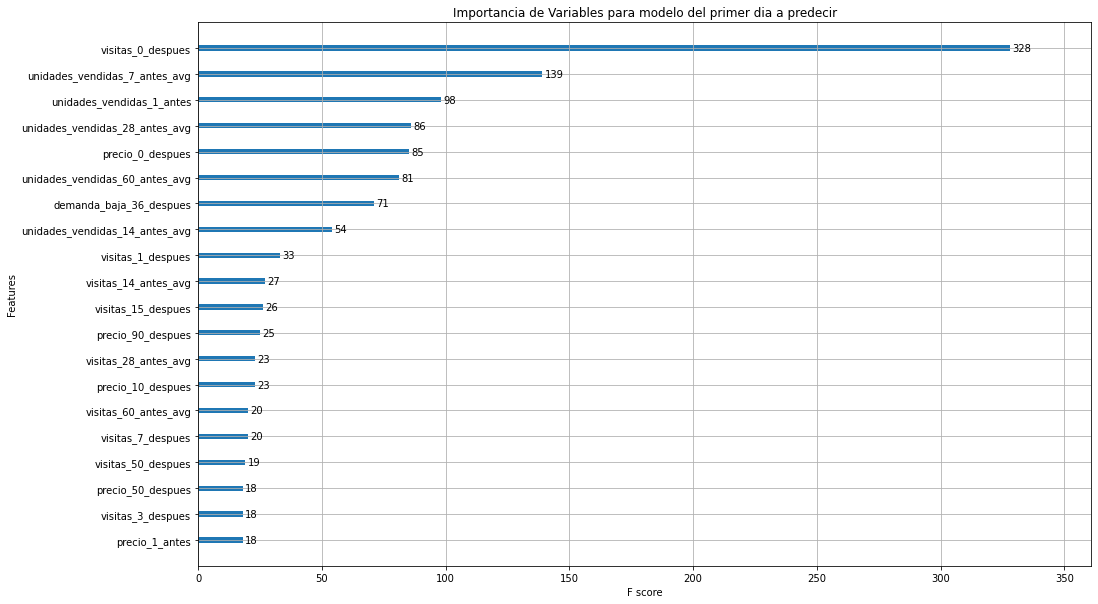

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
xgb.plot_importance(results[1][1],ax=ax, max_num_features=20,importance_type='weight',title="Importancia de Variables para modelo del primer dia a predecir");